In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# 1.1 Getting Correspondences

In [14]:
book_img = cv2.imread('cv_cover.jpg', cv2.IMREAD_GRAYSCALE)#lazem grayscale 3shan feature detection
#print(book_img.shape)
cap = cv2.VideoCapture('book.mov')
ret, frame = cap.read()#read gets the first frame and ret is just a flag to check if successful
cap.release()

if ret:
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)#lazem grayscale 3shan feature detection
else:
    raise ValueError("Error, Couldnt read from video.")

sift = cv2.SIFT_create()
#sift. to get keypoints and their descriptors
keypoints1, descriptors1 = sift.detectAndCompute(book_img, None)
keypoints2, descriptors2 = sift.detectAndCompute(frame_gray, None)



In [15]:
#brute force matcher takes every descriptor in img and compares it to every descriptor in the other img and returns the best match
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)#k=2 means it will return the 2 best matches for each descriptor
#y3ni lkol descriptor fe img1 2 matches fe img2
#matches is a list of lists

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if (m.distance/n.distance) < 0.75:
        good_matches.append(m)

#Take the top 50 good matches
good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]


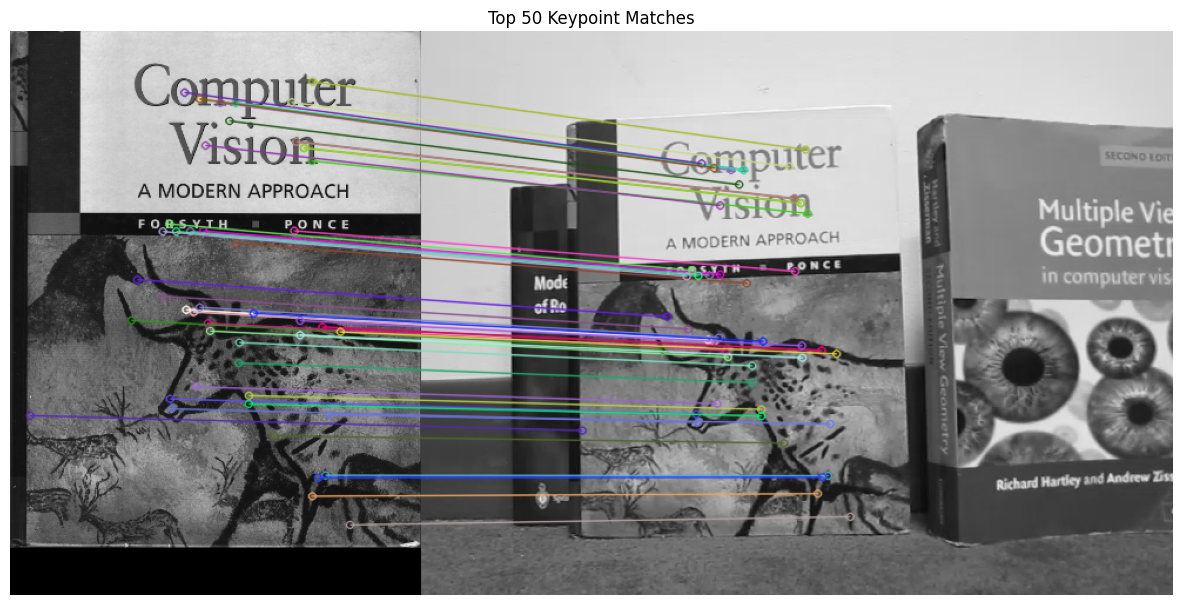

In [16]:
matched_img = cv2.drawMatches(book_img, keypoints1, frame_gray, keypoints2, good_matches, None, flags=2)
# print(book_img.shape)
# print(frame_gray.shape)

plt.figure(figsize=(15, 10))
plt.imshow(matched_img, cmap='gray')
plt.title("Top 50 Keypoint Matches")
plt.axis('off')
plt.show()


# 1.2 Compute the Homography Parameters

In [17]:
def compute_homography(src_pts, dst_pts):
    
    #src_pts: List or array of (x, y) points in the first image
    #dst_pts: Corresponding list or array of (x', y') points in the second image

    if len(src_pts) < 4:
        raise ValueError("Need at least 4 point correspondences.")

    A = []
    for (x, y), (x_prime, y_prime) in zip(src_pts, dst_pts):
        A.append([x, y, 1, 0, 0, 0, -x * x_prime, -y * x_prime])
        A.append([0, 0, 0, x, y, 1, -x * y_prime, -y * y_prime])

    A = np.array(A) #2nx8 matrix
    b = np.array(dst_pts).reshape(-1)# Flatten the dst_pts array to make it a 1D array,x1',y1',x2',y2'...
    # Solve Ah = b using least squares
    h = np.linalg.lstsq(A, b, rcond=None)[0]# Get the least-squares solution
    

    H = np.append(h, 1).reshape((3, 3))#make h33 = 1 and reshape it to 3x3 matrix
    return H


def compute_homography_ransac(src_pts, dst_pts, threshold=5.0, max_iter=100):
  
    src_pts = np.array(src_pts)
    dst_pts = np.array(dst_pts)
    num_points = len(src_pts)
    best_H = None
    best_inliers = []
    max_inliers = 0

    for _ in range(max_iter):
        #Randomly choose 4 correspondences
        idxs = np.random.choice(num_points, 4, replace=False)
        src_sample = src_pts[idxs]
        dst_sample = dst_pts[idxs]

        #Compute homography from the 4 points
        H = compute_homography(src_sample, dst_sample)

        #Apply H to all src_pts
        src_hom = np.hstack([src_pts, np.ones((num_points, 1))])  # convert to homogeneous coordinates [x y 1]
        proj = (H @ src_hom.T).T 
        proj /= proj[:, 2][:, np.newaxis]  #convert back to hetergeneous coordinates

        #Compute reprojection error
        error = np.linalg.norm(proj[:, :2] - dst_pts, axis=1)

        #Count inliers
        inliers = error < threshold
        num_inliers = np.sum(inliers)

        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_H = H
            best_inliers = inliers

    #recompute H using all inliers
    if max_inliers >= 4:
        best_H = compute_homography(src_pts[best_inliers], dst_pts[best_inliers])
    else:
        raise ValueError("Not enough inliers found.")

    return best_H, best_inliers


def apply_homography(H, points):
    #Apply the homography matrix to the points.

    points_hom = np.hstack([points, np.ones((len(points), 1))])  # Convert to homogeneous coordinates [x y 1]
    transformed = (H @ points_hom.T).T  # Matrix multiplication to apply the homography

    # Convert back to Cartesian coordinates(2D) by dividing by the last coordinate
    transformed /= transformed[:, 2][:, np.newaxis]
    return transformed[:, :2]## Keep only the x and y coordinates



In [18]:
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

original_book_img = cv2.imread("cv_cover.jpg")  
first_frame = frame.copy()
H_test, _ = compute_homography_ransac(src_pts, dst_pts) 

# Store clicked points
clicked_points = {
    "book": [],
    "frame": []
}

def click_event_book(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:#on left click take the x,y coordinates of the click
        pt = np.array([[x, y]])
        clicked_points["book"].append((x, y))
        frame_pt = apply_homography(H_test, pt)[0]
        # Transform from book to frame
        clicked_points["frame"].append(tuple(frame_pt))

        draw_and_update()

def click_event_frame(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        pt = np.array([[x, y]])
        clicked_points["frame"].append((x, y))

        # Transform from frame to book
        book_pt = apply_homography(np.linalg.inv(H_test), pt)[0] # applies inverse of H to get the book point
        clicked_points["book"].append(tuple(book_pt))

        draw_and_update()

def draw_and_update():
    book_copy = original_book_img.copy()
    frame_copy = first_frame.copy()

    for pt in clicked_points["book"]:
        cv2.circle(book_copy, (int(pt[0]), int(pt[1])), 5, (0, 0, 255), -1)

    for pt in clicked_points["frame"]:
        cv2.circle(frame_copy, (int(pt[0]), int(pt[1])), 5, (0, 255, 0), -1)

    cv2.imshow("Book Image", book_copy)
    cv2.imshow("Video Frame", frame_copy)

# Create windows and set mouse callbacks
cv2.namedWindow("Book Image")
cv2.setMouseCallback("Book Image", click_event_book)

cv2.namedWindow("Video Frame")
cv2.setMouseCallback("Video Frame", click_event_frame)

# Initial draw
draw_and_update()

while True:
    key = cv2.waitKey(10)
    if key == 27:  # ESC key to break
        break

cv2.destroyAllWindows()


# 1.3 Calculate Book Coordinates

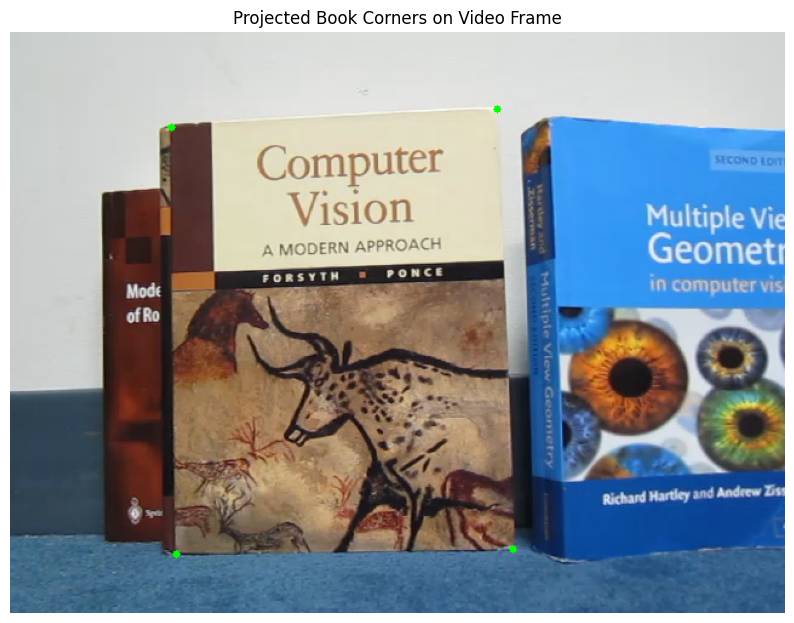

In [19]:
h, w = book_img.shape[:2]
book_corners = np.array([
    [18, 4],
    [w - 1, 3],
    [w - 3, h - 3],
    [16, h - 3]
], dtype=np.float32)

book_corners_proj = apply_homography(H_test, book_corners)
book_corners_proj_int = np.int32(book_corners_proj)#Convert to integer coordinates only for drawing

frame_with_corners = frame.copy()
# cv2.polylines(frame_with_corners, [book_corners_proj_int], isClosed=True, color=(0, 0, 255), thickness=3)

# Draw each corner
for pt in book_corners_proj_int:
    cv2.circle(frame_with_corners, tuple(pt), radius=3, color=(0, 255, 0), thickness=-1)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(frame_with_corners, cv2.COLOR_BGR2RGB))
plt.title("Projected Book Corners on Video Frame")
plt.axis('off')
plt.show()

In [20]:
# # Load the video
# cap = cv2.VideoCapture('ar_source_2.mov')

# # Read the first frame
# ret, v_frame = cap.read()

# if not ret:
#     print("[ERROR] Failed to read the first frame from ar_source.mov.")
#     exit()

# book_corners_int = np.int32(book_corners)
# book_h, book_w = book_img.shape

# # Get the book corner bounds
# x_min, y_min = np.min(book_corners_int, axis=0)
# x_max, y_max = np.max(book_corners_int, axis=0)

# # Frame info
# frame1_h, frame1_w = frame.shape[:2]
# print(f"[INFO] Book video frame shape: width={frame1_w}, height={frame1_h}")

# v_frame_height, v_frame_width = v_frame.shape[:2]
# print(f"[INFO] AR source frame shape: width={v_frame_width}, height={v_frame_height}")

# center_x, center_y = v_frame_width // 2, v_frame_height // 2
# print(f"[INFO] AR frame center: ({center_x}, {center_y})")

# # Crop dimensions and coordinates
# crop_width = x_max - x_min
# crop_height = y_max - y_min
# print(f"[INFO] Crop size: width={crop_width}, height={crop_height}")

# x_start = max(0, center_x - crop_width // 2)
# x_end = min(v_frame_width, center_x + crop_width // 2)
# y_start = max(0, center_y - crop_height // 2)
# y_end = min(v_frame_height, center_y + crop_height // 2)

# print(f"[INFO] Cropping coordinates: x={x_start}:{x_end}, y={y_start}:{y_end}")

# # Crop and resize the AR frame
# cropped_v_frame = v_frame[y_start:y_end, x_start:x_end]
# print(f"[INFO] Cropped AR frame shape: {cropped_v_frame.shape}")

# cropped_frame = cv2.resize(cropped_v_frame, (book_w, book_h))
# print(f"[INFO] Resized AR frame shape: {cropped_frame.shape}")

# # Display the cropped and resized AR frame
# plt.figure(figsize=(10, 8))
# plt.imshow(cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB))
# plt.title("Cropped and Resized AR Frame")
# plt.axis('off')
# plt.show()

# # Prepare source and destination points for homography
# hpanda, wpanda = cropped_frame.shape[:2]
# src_pts = np.float32([[0, 0], [wpanda - 1, 0], [wpanda - 1, hpanda - 1], [0, hpanda - 1]])
# dst_pts = book_corners_proj.astype(np.float32)

# # Compute homography and warp
# H_crop_to_book = compute_homography(src_pts, dst_pts)
# warped_cropped = cv2.warpPerspective(cropped_frame, H_crop_to_book, (frame1_w, frame1_h))

# print(f"[INFO] Warped AR frame shape: {warped_cropped.shape}")

# # Display warped AR frame
# plt.figure(figsize=(10, 8))
# plt.imshow(cv2.cvtColor(warped_cropped, cv2.COLOR_BGR2RGB))
# plt.title("Warped AR Frame")
# plt.axis('off')
# plt.show()

# # Display the original video frame
# plt.figure(figsize=(10, 8))
# plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
# plt.title("Original Book Frame")
# plt.axis('off')
# plt.show()

# # Create mask of non-black pixels in warped AR frame
# gray_warp = cv2.cvtColor(warped_cropped, cv2.COLOR_BGR2GRAY)
# _, mask = cv2.threshold(gray_warp, 10, 255, cv2.THRESH_BINARY)
# mask_inv = cv2.bitwise_not(mask)

# # Prepare 3-channel masks
# mask_3ch = cv2.merge([mask, mask, mask])
# mask_inv_3ch = cv2.merge([mask_inv, mask_inv, mask_inv])

# # Blend AR frame with original book frame
# frame_bg = cv2.bitwise_and(frame, mask_inv_3ch)
# overlay_fg = cv2.bitwise_and(warped_cropped, mask_3ch)
# final_overlay = cv2.add(frame_bg, overlay_fg)

# # Display final result
# plt.figure(figsize=(10, 8))
# plt.imshow(cv2.cvtColor(final_overlay, cv2.COLOR_BGR2RGB))
# plt.title("Final AR Overlay on Book")
# plt.axis('off')
# plt.show()

# # Release video capture
# cap.release()


In [21]:
# # Prepare video readers
# book_cap = cv2.VideoCapture('book.mov')
# ar_cap = cv2.VideoCapture('ar_source.mov')

# frame_count = 0

# book_corners_int = np.int32(book_corners)
# book_h, book_w = book_img.shape

# x_min, y_min = np.min(book_corners_int, axis=0)
# x_max, y_max = np.max(book_corners_int, axis=0)
# # Crop dimensions and coordinates
# crop_width = x_max - x_min
# crop_height = y_max - y_min

# keypoints1, descriptors1 = sift.detectAndCompute(book_img, None)

# while frame_count < 20:
#     ret_book, frame_book = book_cap.read()
#     ret_ar, ar_frame = ar_cap.read()

#     if not ret_book or not ret_ar:
#         print(f"[ERROR] Could not read frame {frame_count} from one of the videos.")
#         break

#     frame_count += 1
#     print(f"Processing frame {frame_count}")

#     frame_gray = cv2.cvtColor(frame_book, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for feature detection

#     ar_frame_height, ar_frame_width = ar_frame.shape[:2]
#     center_x, center_y = ar_frame_width // 2, ar_frame_height // 2

#     x_start = max(0, center_x - crop_width // 2)
#     x_end = min(ar_frame_width, center_x + crop_width // 2)
#     y_start = max(0, center_y - crop_height // 2)
#     y_end = min(ar_frame_height, center_y + crop_height // 2)

#     # Crop and resize the AR frame
#     cropped_ar_frame = ar_frame[y_start:y_end, x_start:x_end]
#     resized_cropped_ar_frame = cv2.resize(cropped_ar_frame, (book_w, book_h))

#     keypoints2, descriptors2 = sift.detectAndCompute(frame_gray, None)
#     matches = bf.knnMatch(descriptors1, descriptors2, k=2)  # k=2 means it will return the 2 best matches for each descriptor

#     good_matches = []
#     for m, n in matches:
#         if (m.distance / n.distance) < 0.75:
#             good_matches.append(m)

#     good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]
#     matched_img = cv2.drawMatches(book_img, keypoints1, frame_gray, keypoints2, good_matches, None, flags=2)

#     src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
#     dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

#     # Compute homography
#     H = compute_homography(src_pts.reshape(-1, 2), dst_pts.reshape(-1, 2))
#     h, w = book_img.shape

#     book_corners = np.array([
#         [18, 4],
#         [w - 1, 3],
#         [w - 3, h - 3],
#         [16, h - 3]
#     ], dtype=np.float32)

#     book_corners_proj = apply_homography(H, book_corners)
#     book_corners_proj_int = np.int32(book_corners_proj)  # Convert to integer coordinates for drawing

#     hpanda, wpanda = resized_cropped_ar_frame.shape[:2]
#     src_pts = np.float32([[0, 0], [wpanda - 1, 0], [wpanda - 1, hpanda - 1], [0, hpanda - 1]])
#     dst_pts = book_corners_proj.astype(np.float32)

#     # Compute homography to overlay AR frame onto the book
#     H_crop_to_book = compute_homography(src_pts, dst_pts)
#     warped_cropped = cv2.warpPerspective(resized_cropped_ar_frame, H_crop_to_book, (frame_book.shape[1], frame_book.shape[0]))

#     # Create mask of non-black pixels in warped AR frame
#     gray_warp = cv2.cvtColor(warped_cropped, cv2.COLOR_BGR2GRAY)
#     _, mask = cv2.threshold(gray_warp, 10, 255, cv2.THRESH_BINARY)
#     mask_inv = cv2.bitwise_not(mask)

#     # Prepare 3-channel masks
#     mask_3ch = cv2.merge([mask, mask, mask])
#     mask_inv_3ch = cv2.merge([mask_inv, mask_inv, mask_inv])

#     # Blend AR frame with original book frame
#     frame_bg = cv2.bitwise_and(frame_book, mask_inv_3ch)
#     overlay_fg = cv2.bitwise_and(warped_cropped, mask_3ch)
#     final_overlay = cv2.add(frame_bg, overlay_fg)

#     # Display the cropped and resized AR frame
#     plt.figure(figsize=(10, 8))
#     plt.imshow(cv2.cvtColor(resized_cropped_ar_frame, cv2.COLOR_BGR2RGB))
#     plt.title("Cropped and Resized AR Frame")
#     plt.axis('off')
#     plt.show()

#     # Display final result
#     plt.figure(figsize=(10, 8))
#     plt.imshow(cv2.cvtColor(final_overlay, cv2.COLOR_BGR2RGB))
#     plt.title("Final AR Overlay on Book")
#     plt.axis('off')
#     plt.show()
#     out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (final_overlay.shape[1], final_overlay.shape[0]))
#     out.write(final_overlay)

#     cv2.waitKey(3)  # Wait a bit to allow the next frame


In [22]:
def warp_perspective_manual(src_img, H, output_shape):
    
    H_inv = np.linalg.inv(H)
    height, width = output_shape
    warped = np.zeros((height, width, src_img.shape[2]), dtype=src_img.dtype)

    for y in range(height):
        for x in range(width):
            # Create homogeneous coordinate for destination pixel
            dest_pt = np.array([x, y, 1])
            # Apply inverse homography
            src_pt = H_inv @ dest_pt
            src_pt /= src_pt[2]

            x_src, y_src = src_pt[:2]

            # Round to nearest pixel (nearest neighbor)
            x_src_int = int(round(x_src))
            y_src_int = int(round(y_src))

            # Check if the source coordinate is within bounds
            if 0 <= x_src_int < src_img.shape[1] and 0 <= y_src_int < src_img.shape[0]:
                warped[y, x] = src_img[y_src_int, x_src_int]

    return warped


In [23]:
import cv2
import numpy as np

book_cap = cv2.VideoCapture('book.mov')
ar_cap = cv2.VideoCapture('ar_source_2.mov')
sift = cv2.SIFT_create()
bf = cv2.BFMatcher()
count=0
keypoints1, descriptors1 = sift.detectAndCompute(book_img, None)

book_h, book_w = book_img.shape
book_corners = np.float32([[18, 4], [book_w - 1, 3], [book_w - 3, book_h - 3], [16, book_h - 3]])

# Get video properties
fps = book_cap.get(cv2.CAP_PROP_FPS)
frame_width = int(book_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(book_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_overlay.mp4', fourcc, fps, (frame_width, frame_height))

while True:
    ret_book, frame_book = book_cap.read()
    ret_ar, frame_ar = ar_cap.read()

    if not ret_book or not ret_ar:
        break

    frame_gray = cv2.cvtColor(frame_book, cv2.COLOR_BGR2GRAY)
    keypoints2, descriptors2 = sift.detectAndCompute(frame_gray, None)


    
    if descriptors2 is None or len(descriptors2) < 2:
        out.write(frame_book)
        continue

    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    if len(good_matches) > 10:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

        H,_= compute_homography_ransac(src_pts, dst_pts)
        if H is not None:
            book_corners_proj = apply_homography(H,book_corners)

            
            # Center crop AR frame using book image size
            ar_h, ar_w = frame_ar.shape[:2]
            crop_h, crop_w = book_h, book_w

            center_y, center_x = ar_h // 2, ar_w // 2
            y1 = max(center_y - crop_h // 2, 0)
            y2 = min(center_y + crop_h // 2, ar_h)
            x1 = max(center_x - crop_w // 2, 0)
            x2 = min(center_x + crop_w // 2, ar_w)

            cropped_ar = frame_ar[y1:y2, x1:x2]
            resized_ar = cv2.resize(cropped_ar, (book_w, book_h))
            
            # count+=1
            # if count==1:
            #     plt.figure(figsize=(10, 8))
            #     plt.imshow(cv2.cvtColor(cropped_ar, cv2.COLOR_BGR2RGB))
            #     plt.title("Cropped and Resized AR Frame")
            #     print(f"cropped_ar shape: {cropped_ar.shape}")
            #     plt.figure(figsize=(10, 8))
            #     plt.imshow(cv2.cvtColor(resized_ar, cv2.COLOR_BGR2RGB))
            #     plt.title("Cropped and Resized AR Frame")
            #     print(f"resized_ar shape: {resized_ar.shape}")


            ###hpanda, wpanda = resized_ar.shape[:2]

            ###src_pts_ar = np.float32([[0, 0], [wpanda - 1, 0], [wpanda - 1, hpanda - 1], [0, hpanda - 1]])
            dst_pts_ar = book_corners_proj.astype(np.float32)

            ###H_ar_to_book,_ = compute_homography_ransac(src_pts_ar, dst_pts_ar)
            warped_ar = cv2.warpPerspective(resized_ar, H, (frame_book.shape[1], frame_book.shape[0]))
            # plt.figure(figsize=(10, 8))
            # plt.imshow(cv2.cvtColor(warped_ar, cv2.COLOR_BGR2RGB))
            # plt.title("Cropped and Resized AR Frame")
            # Masking
            # Create a blank mask the same size as the frame
            mask_bin = np.zeros((frame_book.shape[0], frame_book.shape[1]), dtype=np.uint8)

            # Fill the projected book area as white (255)
            cv2.fillConvexPoly(mask_bin, np.int32(dst_pts_ar), 255)

            mask_inv = cv2.bitwise_not(mask_bin)
            mask_3ch = cv2.merge([mask_bin] * 3)
            mask_inv_3ch = cv2.merge([mask_inv] * 3)

            bg = cv2.bitwise_and(frame_book, mask_inv_3ch)
            fg = cv2.bitwise_and(warped_ar, mask_3ch)
            overlay = cv2.add(bg, fg)

            out.write(overlay)
        else:
            out.write(frame_book)
    else:
        out.write(frame_book)

book_cap.release()
ar_cap.release()
out.release()